# **Dự báo thời tiết**

Chương trình dự báo thời tiết bằng Tensorflow. Được xây dựng theo mô hình Mạng tái tạo - Recurrent Neural Network (RNN).

# Khai báo thư viện

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Kết nối với drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Xây dựng hàm

### Tách tập dữ liệu

Bộ dữ liệu gốc sẽ được tách thành:

* X: Đầu vào, Mỗi phần tử mảng là một tập chứa `window_size` giờ.

* y: Đầu ra, Mỗi phần tử mảng là dữ liệu 1 giờ sau.

Với `window_size` = 6 thì mỗi một phần tử cùng chỉ số vị trí có dạng như sau:

![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

=> Có thể hiểu X là Input và y là Label!

In [2]:
def df_to_X_y(df, window_size = 6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [r for r in df_as_np[i : i + window_size]]
    X.append(row)
    label = []
    for j in range(len(df.columns) - 4):
      label.append(df_as_np[i + window_size][j])
    y.append(label)
  return np.array(X), np.array(y)

### Chuyển đổi kiểu dữ liệu

Chuyển dữ liệu về kiểu `float32` để mô hình có thể học được.

In [3]:
def to_float32(data):
  return np.asarray(data).astype('float32')

### Chuẩn hóa dữ liệu

Chuẩn hóa dữ liệu giúp mô hình xử lý nhanh và nhẹ hơn.

In [4]:
def nomralize_data(data, mean, std):
  return (data - mean) / std

### Giải mã dữ liệu chuẩn hóa

Đưa dữ liệu dạng chuẩn hóa về dạng ban đầu

In [5]:
def re_nomralize_data(arr, index=0):
  arr = (arr * std[index]) + mean[index]
  return arr

### Trực quan hóa dữ liệu

Vẽ biểu đồ giúp quan sát dễ dàng hơn.

Tất cả đặc trưng

In [6]:
def plot_predictions(model, X, y, list_name, show=True, start=0, end=-1):
  
  preds, actuals = [], []
  data = {}
  title = []

  predictions = model.predict(X)
  for i in range(predictions.shape[1]):
    preds.append(re_nomralize_data(predictions[:, i], i))
    actuals.append(re_nomralize_data(y[:, i], i))
    
  # Lấy danh sách các đặc trưng trừ đặc trưng thời gian lượng giác
  list_name = list(list_name.columns)
  list_name.remove('Ngày sin')
  list_name.remove('Ngày cos')
  list_name.remove('Năm sin')
  list_name.remove('Năm cos')

  # Đưa thông số dữ liệu vào biểu đồ để hiển thị
  for i in range(predictions.shape[1]):
    Name_pred = list_name[i] + ' dự đoán'
    Name_actual = list_name[i] + ' thực tế' 
    data[Name_pred] = preds[i]
    data[Name_actual] = actuals[i]

  df = pd.DataFrame(data=data)

  # Hiển thị
  if show:
    plt.figure(figsize=(24, 10))

  for i in df[start : end]:
    title.append(i)
    if show:
      plt.plot(df[i])

  if show:
    plt.legend(title)
  
  return df

Từng đặc trưng

In [7]:
def plot_prediction(name, start=0, end=-1):
  post_processed_df = plot_predictions(model, X_test, y_test, df_temp, False)
  name_pred = name + ' dự đoán'
  name_actual = name + ' thực tế'
  plt.figure(figsize=(24, 10))
  plt.plot(post_processed_df[name_pred][start:end])
  plt.plot(post_processed_df[name_actual][start:end])
  plt.legend([name_pred, name_actual])

# Bộ dữ liệu thời tiết

Sử dụng bộ dữ liệu tại trang <a href="https://www.visualcrossing.com/weather/weather-data-services">**Visual crossing**</a>.

Bộ dữ liệu bao gồm 14 đặc trưng bao gồm: nhiệt độ, áp suất khí quyển, độ ẩm,... Được thu nhập mỗi tiếng từ 01/01/2020 đến 12/09/2022

In [8]:
# Đường dẫn
drive_path = 'drive/MyDrive/Internship/RNN/Data'
xlsx_path = os.path.join(drive_path, 'Data.xlsx')

# Đọc flie
df = pd.read_excel(xlsx_path)

# Đưa đặc trưng ngày giờ làm index
df.index = pd.to_datetime(df['Ngày giờ'], format='%Y-%m-%d %H:%M:%S')

# Xóa các dữ liệu không cần thiết
df = df.drop(['Ngày giờ', 'Kết luận', 'Trạng thái mưa', 'Mưa'], axis=1)

# Xử lý dữ liệu
## Chuyển từ hai giá trị (0 và 100) sang (0 và 1)
df['Xác suất mưa'] = df['Xác suất mưa'] / 100
## Bổ sung dữ liệu trống (gán giá trị là mean)
for index, value in enumerate(df['Áp suất']):
  if value > 0:
    pass
  else:
    df['Áp suất'][index] = df['Áp suất'].mean()
for index, value in enumerate(df['Tầm nhìn']):
  if value > 0.0:
    pass
  else:
    df['Tầm nhìn'][index] = df['Tầm nhìn'].mean()
for index, value in enumerate(df['Chỉ số UV']):
  if value > 0:
    pass
  else:
    df['Chỉ số UV'][index] = df['Chỉ số UV'].mean()

# Thêm hệ số ngày và năm
day = 60 * 60 * 24
year = 365.2425 * day
df['Giây'] = df.index.map(pd.Timestamp.timestamp)
df['Ngày sin'] = np.sin(df['Giây'] * (2 * np.pi / day))
df['Ngày cos'] = np.cos(df['Giây'] * (2 * np.pi / day))
df['Năm sin'] = np.sin(df['Giây'] * (2 * np.pi / year))
df['Năm cos'] = np.cos(df['Giây'] * (2 * np.pi / year))
df = df.drop('Giây', axis=1)

# Thiết lập thông số huấn luyện

In [9]:
# Đường dẫn model
model_name = 'Best_Model'
drive_path = 'drive/MyDrive/Internship/RNN/Model'
model_path = os.path.join(drive_path, model_name)

# Thông số học
EPOCHS = 200
LR = 1e-5

# Số đầu vào để dự đoán
WINDOW_SIZE = 24

# Thông số chia tập dữ liệu
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

# Check point
cp_bs = ModelCheckpoint(model_path, save_best_only=True) # best saving
cp_es = EarlyStopping(patience=2)  # early stoping

# Huấn luyện mô hình

### Chia dữ liệu

Từ tập X và y (Input và Label) chia thành các tập:
 * Train: Tập dùng để huấn luyện có tỉ lệ: `train_ratio`
 * Validation: Tập dùng để tối ưu có tỉ lệ: `val_ratio`
 * Test: Tập dùng để kiểm thử chiếm số còn lại

In [10]:
# Tạo dữ liệu tạm
df_temp = df

# Tách dữ liệu
X, y = df_to_X_y(df_temp, WINDOW_SIZE)

# Chia dữ liệu
length = len(X)
begin = int(length * TRAIN_RATIO)
end = int(length * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X[ : begin], y[ : begin]
X_val, y_val = X[begin : end], y[begin : end]
X_test, y_test = X[end : ], y[end : ]

# Chuyển đổi kiểu dữ liệu
X_train = to_float32(X_train)
X_val = to_float32(X_val)
X_test = to_float32(X_test)

y_train = to_float32(y_train)
y_val = to_float32(y_val)
y_test = to_float32(y_test)

### Chuẩn hóa dữ liệu

Lưu trữ các giá trị `mean` và `std`

In [11]:
mean, std = [], []

for i in range(len(df_temp.columns) - 4):
  mean.append(np.mean(X_train[:, :, i]))
  std.append(np.std(X_train[:, :, i]))

Chuẩn hóa

In [12]:
for i in range(len(df_temp.columns) - 4):
  X_train[:, :, i] = nomralize_data(X_train[:, :, i], mean[i], std[i])
  X_val[:, :, i] = nomralize_data(X_val[:, :, i], mean[i], std[i])
  X_test[:, :, i] = nomralize_data(X_test[:, :, i], mean[i], std[i])

  y_train[:, i] = nomralize_data(y_train[:, i], mean[i], std[i])
  y_val[:, i] = nomralize_data(y_val[:, i], mean[i], std[i])
  y_test[:, i] = nomralize_data(y_test[:, i], mean[i], std[i])

### Mô hình

##### Tạo mô hình huấn luyện

In [13]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, len(df_temp.columns))))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(96, 'relu'))
model.add(Dense(32, 'relu'))
model.add(Dense(len(df_temp.columns) - 4, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR), metrics=[RootMeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            20480     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 96)                3168      
                                                                 
 dense_1 (Dense)             (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 11)                363       
                                                                 
Total params: 39,531
Trainable params: 39,531
Non-trainable params: 0
_________________________________________________________________


##### Huấn luyện

In [14]:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[cp_bs, cp_es])

Epoch 1/200
516/518 [============================>.] - ETA: 0s - loss: 0.9597 - root_mean_squared_error: 0.9796

518/518 [==============================] - 31s 49ms/step - loss: 0.9602 - root_mean_squared_error: 0.9799 - val_loss: 0.9266 - val_root_mean_squared_error: 0.9626
Epoch 2/200
516/518 [============================>.] - ETA: 0s - loss: 0.8982 - root_mean_squared_error: 0.9477

518/518 [==============================] - 24s 47ms/step - loss: 0.8980 - root_mean_squared_error: 0.9476 - val_loss: 0.8561 - val_root_mean_squared_error: 0.9253
Epoch 3/200
516/518 [============================>.] - ETA: 0s - loss: 0.8407 - root_mean_squared_error: 0.9169

518/518 [==============================] - 24s 46ms/step - loss: 0.8407 - root_mean_squared_error: 0.9169 - val_loss: 0.8079 - val_root_mean_squared_error: 0.8988
Epoch 4/200
517/518 [============================>.] - ETA: 0s - loss: 0.7937 - root_mean_squared_error: 0.8909

518/518 [==============================] - 25s 48ms/step - loss: 0.7936 - root_mean_squared_error: 0.8908 - val_loss: 0.7611 - val_root_mean_squared_error: 0.8724
Epoch 5/200
518/518 [==============================] - ETA: 0s - loss: 0.7447 - root_mean_squared_error: 0.8629

518/518 [==============================] - 23s 45ms/step - loss: 0.7447 - root_mean_squared_error: 0.8629 - val_loss: 0.7094 - val_root_mean_squared_error: 0.8423
Epoch 6/200
518/518 [==============================] - ETA: 0s - loss: 0.6926 - root_mean_squared_error: 0.8322

518/518 [==============================] - 24s 47ms/step - loss: 0.6926 - root_mean_squared_error: 0.8322 - val_loss: 0.6620 - val_root_mean_squared_error: 0.8136
Epoch 7/200
518/518 [==============================] - ETA: 0s - loss: 0.6429 - root_mean_squared_error: 0.8018

518/518 [==============================] - 24s 46ms/step - loss: 0.6429 - root_mean_squared_error: 0.8018 - val_loss: 0.6263 - val_root_mean_squared_error: 0.7914
Epoch 8/200
517/518 [============================>.] - ETA: 0s - loss: 0.6018 - root_mean_squared_error: 0.7757

518/518 [==============================] - 24s 46ms/step - loss: 0.6017 - root_mean_squared_error: 0.7757 - val_loss: 0.6020 - val_root_mean_squared_error: 0.7759
Epoch 9/200
517/518 [============================>.] - ETA: 0s - loss: 0.5713 - root_mean_squared_error: 0.7559

518/518 [==============================] - 22s 43ms/step - loss: 0.5713 - root_mean_squared_error: 0.7558 - val_loss: 0.5867 - val_root_mean_squared_error: 0.7659
Epoch 10/200
517/518 [============================>.] - ETA: 0s - loss: 0.5492 - root_mean_squared_error: 0.7411

518/518 [==============================] - 23s 45ms/step - loss: 0.5491 - root_mean_squared_error: 0.7410 - val_loss: 0.5745 - val_root_mean_squared_error: 0.7580
Epoch 11/200
517/518 [============================>.] - ETA: 0s - loss: 0.5322 - root_mean_squared_error: 0.7295

518/518 [==============================] - 23s 44ms/step - loss: 0.5322 - root_mean_squared_error: 0.7295 - val_loss: 0.5625 - val_root_mean_squared_error: 0.7500
Epoch 12/200
516/518 [============================>.] - ETA: 0s - loss: 0.5185 - root_mean_squared_error: 0.7201

518/518 [==============================] - 23s 44ms/step - loss: 0.5185 - root_mean_squared_error: 0.7200 - val_loss: 0.5536 - val_root_mean_squared_error: 0.7441
Epoch 13/200
517/518 [============================>.] - ETA: 0s - loss: 0.5067 - root_mean_squared_error: 0.7119

518/518 [==============================] - 24s 47ms/step - loss: 0.5068 - root_mean_squared_error: 0.7119 - val_loss: 0.5447 - val_root_mean_squared_error: 0.7381
Epoch 14/200
516/518 [============================>.] - ETA: 0s - loss: 0.4965 - root_mean_squared_error: 0.7046

518/518 [==============================] - 23s 45ms/step - loss: 0.4965 - root_mean_squared_error: 0.7047 - val_loss: 0.5377 - val_root_mean_squared_error: 0.7333
Epoch 15/200
517/518 [============================>.] - ETA: 0s - loss: 0.4874 - root_mean_squared_error: 0.6982

518/518 [==============================] - 23s 44ms/step - loss: 0.4874 - root_mean_squared_error: 0.6981 - val_loss: 0.5321 - val_root_mean_squared_error: 0.7295
Epoch 16/200
517/518 [============================>.] - ETA: 0s - loss: 0.4792 - root_mean_squared_error: 0.6923

518/518 [==============================] - 26s 50ms/step - loss: 0.4793 - root_mean_squared_error: 0.6923 - val_loss: 0.5240 - val_root_mean_squared_error: 0.7239
Epoch 17/200
517/518 [============================>.] - ETA: 0s - loss: 0.4720 - root_mean_squared_error: 0.6870

518/518 [==============================] - 25s 49ms/step - loss: 0.4720 - root_mean_squared_error: 0.6870 - val_loss: 0.5185 - val_root_mean_squared_error: 0.7201
Epoch 18/200
518/518 [==============================] - ETA: 0s - loss: 0.4654 - root_mean_squared_error: 0.6822

518/518 [==============================] - 27s 52ms/step - loss: 0.4654 - root_mean_squared_error: 0.6822 - val_loss: 0.5138 - val_root_mean_squared_error: 0.7168
Epoch 19/200
517/518 [============================>.] - ETA: 0s - loss: 0.4595 - root_mean_squared_error: 0.6779

518/518 [==============================] - 28s 54ms/step - loss: 0.4595 - root_mean_squared_error: 0.6779 - val_loss: 0.5082 - val_root_mean_squared_error: 0.7129
Epoch 20/200
518/518 [==============================] - ETA: 0s - loss: 0.4540 - root_mean_squared_error: 0.6738

518/518 [==============================] - 26s 49ms/step - loss: 0.4540 - root_mean_squared_error: 0.6738 - val_loss: 0.5036 - val_root_mean_squared_error: 0.7097
Epoch 21/200
517/518 [============================>.] - ETA: 0s - loss: 0.4489 - root_mean_squared_error: 0.6700

518/518 [==============================] - 28s 55ms/step - loss: 0.4490 - root_mean_squared_error: 0.6700 - val_loss: 0.4978 - val_root_mean_squared_error: 0.7056
Epoch 22/200
517/518 [============================>.] - ETA: 0s - loss: 0.4443 - root_mean_squared_error: 0.6666

518/518 [==============================] - 25s 49ms/step - loss: 0.4444 - root_mean_squared_error: 0.6666 - val_loss: 0.4948 - val_root_mean_squared_error: 0.7034
Epoch 23/200
518/518 [==============================] - ETA: 0s - loss: 0.4400 - root_mean_squared_error: 0.6634

518/518 [==============================] - 25s 48ms/step - loss: 0.4400 - root_mean_squared_error: 0.6634 - val_loss: 0.4907 - val_root_mean_squared_error: 0.7005
Epoch 24/200
517/518 [============================>.] - ETA: 0s - loss: 0.4361 - root_mean_squared_error: 0.6604

518/518 [==============================] - 27s 51ms/step - loss: 0.4361 - root_mean_squared_error: 0.6604 - val_loss: 0.4866 - val_root_mean_squared_error: 0.6975
Epoch 25/200
518/518 [==============================] - ETA: 0s - loss: 0.4324 - root_mean_squared_error: 0.6576

518/518 [==============================] - 27s 51ms/step - loss: 0.4324 - root_mean_squared_error: 0.6576 - val_loss: 0.4839 - val_root_mean_squared_error: 0.6956
Epoch 26/200
517/518 [============================>.] - ETA: 0s - loss: 0.4290 - root_mean_squared_error: 0.6550

518/518 [==============================] - 26s 50ms/step - loss: 0.4289 - root_mean_squared_error: 0.6549 - val_loss: 0.4796 - val_root_mean_squared_error: 0.6926
Epoch 27/200
516/518 [============================>.] - ETA: 0s - loss: 0.4258 - root_mean_squared_error: 0.6525

518/518 [==============================] - 23s 45ms/step - loss: 0.4257 - root_mean_squared_error: 0.6525 - val_loss: 0.4764 - val_root_mean_squared_error: 0.6902
Epoch 28/200
517/518 [============================>.] - ETA: 0s - loss: 0.4226 - root_mean_squared_error: 0.6501

518/518 [==============================] - 25s 47ms/step - loss: 0.4227 - root_mean_squared_error: 0.6501 - val_loss: 0.4745 - val_root_mean_squared_error: 0.6888
Epoch 29/200
517/518 [============================>.] - ETA: 0s - loss: 0.4197 - root_mean_squared_error: 0.6479

518/518 [==============================] - 26s 50ms/step - loss: 0.4198 - root_mean_squared_error: 0.6479 - val_loss: 0.4700 - val_root_mean_squared_error: 0.6855
Epoch 30/200
518/518 [==============================] - ETA: 0s - loss: 0.4170 - root_mean_squared_error: 0.6458

518/518 [==============================] - 24s 46ms/step - loss: 0.4170 - root_mean_squared_error: 0.6458 - val_loss: 0.4684 - val_root_mean_squared_error: 0.6844
Epoch 31/200
517/518 [============================>.] - ETA: 0s - loss: 0.4145 - root_mean_squared_error: 0.6438

518/518 [==============================] - 24s 46ms/step - loss: 0.4144 - root_mean_squared_error: 0.6438 - val_loss: 0.4645 - val_root_mean_squared_error: 0.6815
Epoch 32/200
517/518 [============================>.] - ETA: 0s - loss: 0.4120 - root_mean_squared_error: 0.6419

518/518 [==============================] - 23s 45ms/step - loss: 0.4120 - root_mean_squared_error: 0.6419 - val_loss: 0.4622 - val_root_mean_squared_error: 0.6798
Epoch 33/200
516/518 [============================>.] - ETA: 0s - loss: 0.4095 - root_mean_squared_error: 0.6399

518/518 [==============================] - 23s 45ms/step - loss: 0.4096 - root_mean_squared_error: 0.6400 - val_loss: 0.4606 - val_root_mean_squared_error: 0.6787
Epoch 34/200
517/518 [============================>.] - ETA: 0s - loss: 0.4074 - root_mean_squared_error: 0.6383

518/518 [==============================] - 23s 44ms/step - loss: 0.4074 - root_mean_squared_error: 0.6383 - val_loss: 0.4591 - val_root_mean_squared_error: 0.6776
Epoch 35/200
518/518 [==============================] - ETA: 0s - loss: 0.4052 - root_mean_squared_error: 0.6366

518/518 [==============================] - 24s 45ms/step - loss: 0.4052 - root_mean_squared_error: 0.6366 - val_loss: 0.4563 - val_root_mean_squared_error: 0.6755
Epoch 36/200
516/518 [============================>.] - ETA: 0s - loss: 0.4033 - root_mean_squared_error: 0.6350

518/518 [==============================] - 23s 44ms/step - loss: 0.4032 - root_mean_squared_error: 0.6350 - val_loss: 0.4546 - val_root_mean_squared_error: 0.6743
Epoch 37/200
517/518 [============================>.] - ETA: 0s - loss: 0.4012 - root_mean_squared_error: 0.6334

518/518 [==============================] - 24s 47ms/step - loss: 0.4012 - root_mean_squared_error: 0.6334 - val_loss: 0.4527 - val_root_mean_squared_error: 0.6728
Epoch 38/200
517/518 [============================>.] - ETA: 0s - loss: 0.3992 - root_mean_squared_error: 0.6318

518/518 [==============================] - 23s 45ms/step - loss: 0.3993 - root_mean_squared_error: 0.6319 - val_loss: 0.4501 - val_root_mean_squared_error: 0.6709
Epoch 39/200
517/518 [============================>.] - ETA: 0s - loss: 0.3974 - root_mean_squared_error: 0.6304

518/518 [==============================] - 23s 44ms/step - loss: 0.3974 - root_mean_squared_error: 0.6304 - val_loss: 0.4488 - val_root_mean_squared_error: 0.6699
Epoch 40/200
516/518 [============================>.] - ETA: 0s - loss: 0.3953 - root_mean_squared_error: 0.6287

518/518 [==============================] - 24s 46ms/step - loss: 0.3957 - root_mean_squared_error: 0.6290 - val_loss: 0.4465 - val_root_mean_squared_error: 0.6682
Epoch 41/200
517/518 [============================>.] - ETA: 0s - loss: 0.3940 - root_mean_squared_error: 0.6277

518/518 [==============================] - 24s 46ms/step - loss: 0.3940 - root_mean_squared_error: 0.6277 - val_loss: 0.4451 - val_root_mean_squared_error: 0.6671
Epoch 42/200
517/518 [============================>.] - ETA: 0s - loss: 0.3923 - root_mean_squared_error: 0.6264

518/518 [==============================] - 23s 45ms/step - loss: 0.3923 - root_mean_squared_error: 0.6263 - val_loss: 0.4433 - val_root_mean_squared_error: 0.6658
Epoch 43/200
517/518 [============================>.] - ETA: 0s - loss: 0.3907 - root_mean_squared_error: 0.6250

518/518 [==============================] - 24s 47ms/step - loss: 0.3907 - root_mean_squared_error: 0.6250 - val_loss: 0.4422 - val_root_mean_squared_error: 0.6650
Epoch 44/200
516/518 [============================>.] - ETA: 0s - loss: 0.3892 - root_mean_squared_error: 0.6238

518/518 [==============================] - 24s 46ms/step - loss: 0.3891 - root_mean_squared_error: 0.6238 - val_loss: 0.4402 - val_root_mean_squared_error: 0.6635
Epoch 45/200
517/518 [============================>.] - ETA: 0s - loss: 0.3876 - root_mean_squared_error: 0.6226

518/518 [==============================] - 23s 44ms/step - loss: 0.3876 - root_mean_squared_error: 0.6226 - val_loss: 0.4385 - val_root_mean_squared_error: 0.6622
Epoch 46/200
517/518 [============================>.] - ETA: 0s - loss: 0.3862 - root_mean_squared_error: 0.6214

518/518 [==============================] - 25s 49ms/step - loss: 0.3861 - root_mean_squared_error: 0.6214 - val_loss: 0.4377 - val_root_mean_squared_error: 0.6616
Epoch 47/200
516/518 [============================>.] - ETA: 0s - loss: 0.3847 - root_mean_squared_error: 0.6203

518/518 [==============================] - 23s 45ms/step - loss: 0.3847 - root_mean_squared_error: 0.6202 - val_loss: 0.4365 - val_root_mean_squared_error: 0.6607
Epoch 48/200
516/518 [============================>.] - ETA: 0s - loss: 0.3833 - root_mean_squared_error: 0.6191

518/518 [==============================] - 24s 46ms/step - loss: 0.3833 - root_mean_squared_error: 0.6191 - val_loss: 0.4348 - val_root_mean_squared_error: 0.6594
Epoch 49/200
517/518 [============================>.] - ETA: 0s - loss: 0.3819 - root_mean_squared_error: 0.6180

518/518 [==============================] - 24s 46ms/step - loss: 0.3819 - root_mean_squared_error: 0.6180 - val_loss: 0.4333 - val_root_mean_squared_error: 0.6583
Epoch 50/200
517/518 [============================>.] - ETA: 0s - loss: 0.3806 - root_mean_squared_error: 0.6169

518/518 [==============================] - 23s 45ms/step - loss: 0.3806 - root_mean_squared_error: 0.6169 - val_loss: 0.4317 - val_root_mean_squared_error: 0.6570
Epoch 51/200
517/518 [============================>.] - ETA: 0s - loss: 0.3793 - root_mean_squared_error: 0.6159

518/518 [==============================] - 25s 48ms/step - loss: 0.3793 - root_mean_squared_error: 0.6159 - val_loss: 0.4301 - val_root_mean_squared_error: 0.6558
Epoch 52/200
516/518 [============================>.] - ETA: 0s - loss: 0.3781 - root_mean_squared_error: 0.6149

518/518 [==============================] - 25s 47ms/step - loss: 0.3780 - root_mean_squared_error: 0.6148 - val_loss: 0.4286 - val_root_mean_squared_error: 0.6547
Epoch 53/200
516/518 [============================>.] - ETA: 0s - loss: 0.3769 - root_mean_squared_error: 0.6139

518/518 [==============================] - 24s 46ms/step - loss: 0.3768 - root_mean_squared_error: 0.6138 - val_loss: 0.4275 - val_root_mean_squared_error: 0.6539
Epoch 54/200
517/518 [============================>.] - ETA: 0s - loss: 0.3756 - root_mean_squared_error: 0.6128

518/518 [==============================] - 27s 52ms/step - loss: 0.3756 - root_mean_squared_error: 0.6129 - val_loss: 0.4263 - val_root_mean_squared_error: 0.6529
Epoch 55/200
517/518 [============================>.] - ETA: 0s - loss: 0.3744 - root_mean_squared_error: 0.6119

518/518 [==============================] - 24s 47ms/step - loss: 0.3744 - root_mean_squared_error: 0.6119 - val_loss: 0.4258 - val_root_mean_squared_error: 0.6525
Epoch 56/200
518/518 [==============================] - ETA: 0s - loss: 0.3732 - root_mean_squared_error: 0.6109

518/518 [==============================] - 24s 47ms/step - loss: 0.3732 - root_mean_squared_error: 0.6109 - val_loss: 0.4230 - val_root_mean_squared_error: 0.6504
Epoch 57/200
516/518 [============================>.] - ETA: 0s - loss: 0.3720 - root_mean_squared_error: 0.6099

518/518 [==============================] - 23s 45ms/step - loss: 0.3720 - root_mean_squared_error: 0.6099 - val_loss: 0.4224 - val_root_mean_squared_error: 0.6499
Epoch 58/200
516/518 [============================>.] - ETA: 0s - loss: 0.3709 - root_mean_squared_error: 0.6090

518/518 [==============================] - 24s 46ms/step - loss: 0.3709 - root_mean_squared_error: 0.6090 - val_loss: 0.4219 - val_root_mean_squared_error: 0.6496
Epoch 59/200
518/518 [==============================] - ETA: 0s - loss: 0.3697 - root_mean_squared_error: 0.6080

518/518 [==============================] - 23s 45ms/step - loss: 0.3697 - root_mean_squared_error: 0.6080 - val_loss: 0.4213 - val_root_mean_squared_error: 0.6491
Epoch 60/200
516/518 [============================>.] - ETA: 0s - loss: 0.3681 - root_mean_squared_error: 0.6067

518/518 [==============================] - 23s 45ms/step - loss: 0.3686 - root_mean_squared_error: 0.6072 - val_loss: 0.4193 - val_root_mean_squared_error: 0.6475
Epoch 61/200
517/518 [============================>.] - ETA: 0s - loss: 0.3676 - root_mean_squared_error: 0.6063

518/518 [==============================] - 23s 44ms/step - loss: 0.3676 - root_mean_squared_error: 0.6063 - val_loss: 0.4171 - val_root_mean_squared_error: 0.6458
Epoch 62/200
518/518 [==============================] - 15s 29ms/step - loss: 0.3665 - root_mean_squared_error: 0.6054 - val_loss: 0.4180 - val_root_mean_squared_error: 0.6466
Epoch 63/200
516/518 [============================>.] - ETA: 0s - loss: 0.3655 - root_mean_squared_error: 0.6045

518/518 [==============================] - 26s 49ms/step - loss: 0.3654 - root_mean_squared_error: 0.6045 - val_loss: 0.4163 - val_root_mean_squared_error: 0.6452
Epoch 64/200
517/518 [============================>.] - ETA: 0s - loss: 0.3643 - root_mean_squared_error: 0.6036

518/518 [==============================] - 24s 46ms/step - loss: 0.3644 - root_mean_squared_error: 0.6037 - val_loss: 0.4144 - val_root_mean_squared_error: 0.6438
Epoch 65/200
517/518 [============================>.] - ETA: 0s - loss: 0.3634 - root_mean_squared_error: 0.6028

518/518 [==============================] - 24s 46ms/step - loss: 0.3634 - root_mean_squared_error: 0.6028 - val_loss: 0.4138 - val_root_mean_squared_error: 0.6433
Epoch 66/200
517/518 [============================>.] - ETA: 0s - loss: 0.3625 - root_mean_squared_error: 0.6020

518/518 [==============================] - 24s 47ms/step - loss: 0.3624 - root_mean_squared_error: 0.6020 - val_loss: 0.4119 - val_root_mean_squared_error: 0.6418
Epoch 67/200
517/518 [============================>.] - ETA: 0s - loss: 0.3614 - root_mean_squared_error: 0.6012

518/518 [==============================] - 24s 46ms/step - loss: 0.3614 - root_mean_squared_error: 0.6012 - val_loss: 0.4114 - val_root_mean_squared_error: 0.6414
Epoch 68/200
516/518 [============================>.] - ETA: 0s - loss: 0.3606 - root_mean_squared_error: 0.6005

518/518 [==============================] - 24s 46ms/step - loss: 0.3605 - root_mean_squared_error: 0.6004 - val_loss: 0.4106 - val_root_mean_squared_error: 0.6408
Epoch 69/200
517/518 [============================>.] - ETA: 0s - loss: 0.3595 - root_mean_squared_error: 0.5996

518/518 [==============================] - 24s 47ms/step - loss: 0.3595 - root_mean_squared_error: 0.5996 - val_loss: 0.4097 - val_root_mean_squared_error: 0.6401
Epoch 70/200
516/518 [============================>.] - ETA: 0s - loss: 0.3586 - root_mean_squared_error: 0.5989

518/518 [==============================] - 24s 46ms/step - loss: 0.3586 - root_mean_squared_error: 0.5988 - val_loss: 0.4089 - val_root_mean_squared_error: 0.6394
Epoch 71/200
517/518 [============================>.] - ETA: 0s - loss: 0.3577 - root_mean_squared_error: 0.5981

518/518 [==============================] - 25s 49ms/step - loss: 0.3577 - root_mean_squared_error: 0.5981 - val_loss: 0.4074 - val_root_mean_squared_error: 0.6383
Epoch 72/200
517/518 [============================>.] - ETA: 0s - loss: 0.3567 - root_mean_squared_error: 0.5973

518/518 [==============================] - 23s 44ms/step - loss: 0.3567 - root_mean_squared_error: 0.5973 - val_loss: 0.4074 - val_root_mean_squared_error: 0.6383
Epoch 73/200
518/518 [==============================] - ETA: 0s - loss: 0.3559 - root_mean_squared_error: 0.5965

518/518 [==============================] - 24s 47ms/step - loss: 0.3559 - root_mean_squared_error: 0.5965 - val_loss: 0.4053 - val_root_mean_squared_error: 0.6367
Epoch 74/200
517/518 [============================>.] - ETA: 0s - loss: 0.3550 - root_mean_squared_error: 0.5958

518/518 [==============================] - 24s 46ms/step - loss: 0.3550 - root_mean_squared_error: 0.5958 - val_loss: 0.4045 - val_root_mean_squared_error: 0.6360
Epoch 75/200
516/518 [============================>.] - ETA: 0s - loss: 0.3541 - root_mean_squared_error: 0.5951

518/518 [==============================] - 23s 45ms/step - loss: 0.3541 - root_mean_squared_error: 0.5951 - val_loss: 0.4033 - val_root_mean_squared_error: 0.6351
Epoch 76/200
517/518 [============================>.] - ETA: 0s - loss: 0.3533 - root_mean_squared_error: 0.5944

518/518 [==============================] - 25s 48ms/step - loss: 0.3533 - root_mean_squared_error: 0.5944 - val_loss: 0.4020 - val_root_mean_squared_error: 0.6340
Epoch 77/200
517/518 [============================>.] - ETA: 0s - loss: 0.3524 - root_mean_squared_error: 0.5936

518/518 [==============================] - 24s 46ms/step - loss: 0.3524 - root_mean_squared_error: 0.5936 - val_loss: 0.4010 - val_root_mean_squared_error: 0.6333
Epoch 78/200
517/518 [============================>.] - ETA: 0s - loss: 0.3515 - root_mean_squared_error: 0.5929

518/518 [==============================] - 24s 47ms/step - loss: 0.3515 - root_mean_squared_error: 0.5929 - val_loss: 0.4006 - val_root_mean_squared_error: 0.6329
Epoch 79/200
517/518 [============================>.] - ETA: 0s - loss: 0.3507 - root_mean_squared_error: 0.5922

518/518 [==============================] - 25s 49ms/step - loss: 0.3507 - root_mean_squared_error: 0.5922 - val_loss: 0.3992 - val_root_mean_squared_error: 0.6318
Epoch 80/200
516/518 [============================>.] - ETA: 0s - loss: 0.3498 - root_mean_squared_error: 0.5914

518/518 [==============================] - 23s 45ms/step - loss: 0.3499 - root_mean_squared_error: 0.5915 - val_loss: 0.3988 - val_root_mean_squared_error: 0.6315
Epoch 81/200
516/518 [============================>.] - ETA: 0s - loss: 0.3491 - root_mean_squared_error: 0.5909

518/518 [==============================] - 24s 46ms/step - loss: 0.3491 - root_mean_squared_error: 0.5908 - val_loss: 0.3977 - val_root_mean_squared_error: 0.6306
Epoch 82/200
517/518 [============================>.] - ETA: 0s - loss: 0.3484 - root_mean_squared_error: 0.5902

518/518 [==============================] - 23s 44ms/step - loss: 0.3483 - root_mean_squared_error: 0.5902 - val_loss: 0.3973 - val_root_mean_squared_error: 0.6303
Epoch 83/200
517/518 [============================>.] - ETA: 0s - loss: 0.3475 - root_mean_squared_error: 0.5895

518/518 [==============================] - 24s 47ms/step - loss: 0.3475 - root_mean_squared_error: 0.5895 - val_loss: 0.3963 - val_root_mean_squared_error: 0.6295
Epoch 84/200
516/518 [============================>.] - ETA: 0s - loss: 0.3468 - root_mean_squared_error: 0.5889

518/518 [==============================] - 24s 46ms/step - loss: 0.3467 - root_mean_squared_error: 0.5888 - val_loss: 0.3951 - val_root_mean_squared_error: 0.6286
Epoch 85/200
518/518 [==============================] - ETA: 0s - loss: 0.3460 - root_mean_squared_error: 0.5882

518/518 [==============================] - 23s 44ms/step - loss: 0.3460 - root_mean_squared_error: 0.5882 - val_loss: 0.3941 - val_root_mean_squared_error: 0.6278
Epoch 86/200
518/518 [==============================] - ETA: 0s - loss: 0.3452 - root_mean_squared_error: 0.5876

518/518 [==============================] - 24s 46ms/step - loss: 0.3452 - root_mean_squared_error: 0.5876 - val_loss: 0.3932 - val_root_mean_squared_error: 0.6270
Epoch 87/200
517/518 [============================>.] - ETA: 0s - loss: 0.3445 - root_mean_squared_error: 0.5869

518/518 [==============================] - 25s 47ms/step - loss: 0.3445 - root_mean_squared_error: 0.5869 - val_loss: 0.3923 - val_root_mean_squared_error: 0.6263
Epoch 88/200
517/518 [============================>.] - ETA: 0s - loss: 0.3438 - root_mean_squared_error: 0.5863

518/518 [==============================] - 24s 46ms/step - loss: 0.3437 - root_mean_squared_error: 0.5863 - val_loss: 0.3913 - val_root_mean_squared_error: 0.6255
Epoch 89/200
517/518 [============================>.] - ETA: 0s - loss: 0.3430 - root_mean_squared_error: 0.5856

518/518 [==============================] - 24s 46ms/step - loss: 0.3430 - root_mean_squared_error: 0.5857 - val_loss: 0.3907 - val_root_mean_squared_error: 0.6251
Epoch 90/200
518/518 [==============================] - ETA: 0s - loss: 0.3423 - root_mean_squared_error: 0.5851

518/518 [==============================] - 24s 46ms/step - loss: 0.3423 - root_mean_squared_error: 0.5851 - val_loss: 0.3899 - val_root_mean_squared_error: 0.6245
Epoch 91/200
517/518 [============================>.] - ETA: 0s - loss: 0.3416 - root_mean_squared_error: 0.5845

518/518 [==============================] - 25s 48ms/step - loss: 0.3416 - root_mean_squared_error: 0.5845 - val_loss: 0.3893 - val_root_mean_squared_error: 0.6240
Epoch 92/200
516/518 [============================>.] - ETA: 0s - loss: 0.3410 - root_mean_squared_error: 0.5839

518/518 [==============================] - 24s 46ms/step - loss: 0.3409 - root_mean_squared_error: 0.5839 - val_loss: 0.3879 - val_root_mean_squared_error: 0.6228
Epoch 93/200
516/518 [============================>.] - ETA: 0s - loss: 0.3404 - root_mean_squared_error: 0.5834

518/518 [==============================] - 25s 48ms/step - loss: 0.3402 - root_mean_squared_error: 0.5833 - val_loss: 0.3874 - val_root_mean_squared_error: 0.6224
Epoch 94/200
517/518 [============================>.] - ETA: 0s - loss: 0.3397 - root_mean_squared_error: 0.5828

518/518 [==============================] - 24s 46ms/step - loss: 0.3396 - root_mean_squared_error: 0.5828 - val_loss: 0.3864 - val_root_mean_squared_error: 0.6216
Epoch 95/200
517/518 [============================>.] - ETA: 0s - loss: 0.3389 - root_mean_squared_error: 0.5822

518/518 [==============================] - 24s 46ms/step - loss: 0.3389 - root_mean_squared_error: 0.5822 - val_loss: 0.3852 - val_root_mean_squared_error: 0.6206
Epoch 96/200
518/518 [==============================] - 16s 31ms/step - loss: 0.3383 - root_mean_squared_error: 0.5816 - val_loss: 0.3855 - val_root_mean_squared_error: 0.6209
Epoch 97/200
516/518 [============================>.] - ETA: 0s - loss: 0.3376 - root_mean_squared_error: 0.5810

518/518 [==============================] - 23s 45ms/step - loss: 0.3377 - root_mean_squared_error: 0.5811 - val_loss: 0.3837 - val_root_mean_squared_error: 0.6194
Epoch 98/200
518/518 [==============================] - 15s 29ms/step - loss: 0.3370 - root_mean_squared_error: 0.5805 - val_loss: 0.3839 - val_root_mean_squared_error: 0.6196
Epoch 99/200
517/518 [============================>.] - ETA: 0s - loss: 0.3363 - root_mean_squared_error: 0.5799

518/518 [==============================] - 24s 47ms/step - loss: 0.3364 - root_mean_squared_error: 0.5800 - val_loss: 0.3823 - val_root_mean_squared_error: 0.6183
Epoch 100/200
518/518 [==============================] - ETA: 0s - loss: 0.3358 - root_mean_squared_error: 0.5795

518/518 [==============================] - 23s 45ms/step - loss: 0.3358 - root_mean_squared_error: 0.5795 - val_loss: 0.3822 - val_root_mean_squared_error: 0.6183
Epoch 101/200
517/518 [============================>.] - ETA: 0s - loss: 0.3352 - root_mean_squared_error: 0.5789

518/518 [==============================] - 24s 46ms/step - loss: 0.3352 - root_mean_squared_error: 0.5789 - val_loss: 0.3819 - val_root_mean_squared_error: 0.6180
Epoch 102/200
517/518 [============================>.] - ETA: 0s - loss: 0.3346 - root_mean_squared_error: 0.5784

518/518 [==============================] - 24s 46ms/step - loss: 0.3346 - root_mean_squared_error: 0.5784 - val_loss: 0.3805 - val_root_mean_squared_error: 0.6168
Epoch 103/200
516/518 [============================>.] - ETA: 0s - loss: 0.3339 - root_mean_squared_error: 0.5779

518/518 [==============================] - 23s 44ms/step - loss: 0.3340 - root_mean_squared_error: 0.5779 - val_loss: 0.3797 - val_root_mean_squared_error: 0.6162
Epoch 104/200
517/518 [============================>.] - ETA: 0s - loss: 0.3335 - root_mean_squared_error: 0.5775

518/518 [==============================] - 25s 47ms/step - loss: 0.3334 - root_mean_squared_error: 0.5774 - val_loss: 0.3791 - val_root_mean_squared_error: 0.6157
Epoch 105/200
518/518 [==============================] - ETA: 0s - loss: 0.3329 - root_mean_squared_error: 0.5769

518/518 [==============================] - 26s 50ms/step - loss: 0.3329 - root_mean_squared_error: 0.5769 - val_loss: 0.3787 - val_root_mean_squared_error: 0.6154
Epoch 106/200
517/518 [============================>.] - ETA: 0s - loss: 0.3323 - root_mean_squared_error: 0.5764

518/518 [==============================] - 26s 49ms/step - loss: 0.3323 - root_mean_squared_error: 0.5765 - val_loss: 0.3778 - val_root_mean_squared_error: 0.6147
Epoch 107/200
517/518 [============================>.] - ETA: 0s - loss: 0.3317 - root_mean_squared_error: 0.5760

518/518 [==============================] - 26s 50ms/step - loss: 0.3317 - root_mean_squared_error: 0.5760 - val_loss: 0.3767 - val_root_mean_squared_error: 0.6137
Epoch 108/200
518/518 [==============================] - ETA: 0s - loss: 0.3312 - root_mean_squared_error: 0.5755

518/518 [==============================] - 25s 48ms/step - loss: 0.3312 - root_mean_squared_error: 0.5755 - val_loss: 0.3767 - val_root_mean_squared_error: 0.6137
Epoch 109/200
517/518 [============================>.] - ETA: 0s - loss: 0.3307 - root_mean_squared_error: 0.5750

518/518 [==============================] - 25s 49ms/step - loss: 0.3307 - root_mean_squared_error: 0.5751 - val_loss: 0.3766 - val_root_mean_squared_error: 0.6136
Epoch 110/200
517/518 [============================>.] - ETA: 0s - loss: 0.3301 - root_mean_squared_error: 0.5746

518/518 [==============================] - 25s 48ms/step - loss: 0.3301 - root_mean_squared_error: 0.5745 - val_loss: 0.3761 - val_root_mean_squared_error: 0.6133
Epoch 111/200
517/518 [============================>.] - ETA: 0s - loss: 0.3296 - root_mean_squared_error: 0.5741

518/518 [==============================] - 25s 48ms/step - loss: 0.3296 - root_mean_squared_error: 0.5741 - val_loss: 0.3750 - val_root_mean_squared_error: 0.6124
Epoch 112/200
518/518 [==============================] - 16s 31ms/step - loss: 0.3291 - root_mean_squared_error: 0.5737 - val_loss: 0.3752 - val_root_mean_squared_error: 0.6126
Epoch 113/200
517/518 [============================>.] - ETA: 0s - loss: 0.3286 - root_mean_squared_error: 0.5732

518/518 [==============================] - 25s 48ms/step - loss: 0.3286 - root_mean_squared_error: 0.5732 - val_loss: 0.3741 - val_root_mean_squared_error: 0.6116
Epoch 114/200
517/518 [============================>.] - ETA: 0s - loss: 0.3281 - root_mean_squared_error: 0.5728

518/518 [==============================] - 26s 49ms/step - loss: 0.3281 - root_mean_squared_error: 0.5728 - val_loss: 0.3734 - val_root_mean_squared_error: 0.6111
Epoch 115/200
517/518 [============================>.] - ETA: 0s - loss: 0.3277 - root_mean_squared_error: 0.5724

518/518 [==============================] - 25s 48ms/step - loss: 0.3276 - root_mean_squared_error: 0.5724 - val_loss: 0.3726 - val_root_mean_squared_error: 0.6104
Epoch 116/200
517/518 [============================>.] - ETA: 0s - loss: 0.3272 - root_mean_squared_error: 0.5720

518/518 [==============================] - 25s 48ms/step - loss: 0.3271 - root_mean_squared_error: 0.5720 - val_loss: 0.3708 - val_root_mean_squared_error: 0.6089
Epoch 117/200
518/518 [==============================] - 16s 30ms/step - loss: 0.3266 - root_mean_squared_error: 0.5715 - val_loss: 0.3717 - val_root_mean_squared_error: 0.6097
Epoch 118/200
517/518 [============================>.] - ETA: 0s - loss: 0.3262 - root_mean_squared_error: 0.5712

518/518 [==============================] - 24s 46ms/step - loss: 0.3262 - root_mean_squared_error: 0.5711 - val_loss: 0.3706 - val_root_mean_squared_error: 0.6087
Epoch 119/200
518/518 [==============================] - 15s 30ms/step - loss: 0.3257 - root_mean_squared_error: 0.5707 - val_loss: 0.3709 - val_root_mean_squared_error: 0.6090
Epoch 120/200
518/518 [==============================] - 15s 30ms/step - loss: 0.3252 - root_mean_squared_error: 0.5703 - val_loss: 0.3708 - val_root_mean_squared_error: 0.6090


##### Kiểm thử và trực quan hóa tổng quan

,Nhiệt độ dự đoán,Nhiệt độ thực tế,Nhiệt độ cảm giác dự đoán,Nhiệt độ cảm giác thực tế,Sương mù dự đoán,Sương mù thực tế,Độ ẩm dự đoán,Độ ẩm thực tế,Xác suất mưa dự đoán,Xác suất mưa thực tế,...,Hướng gió dự đoán,Hướng gió thực tế,Áp suất dự đoán,Áp suất thực tế,Mây bao phủ dự đoán,Mây bao phủ thực tế,Tầm nhìn dự đoán,Tầm nhìn thực tế,Chỉ số UV dự đoán,Chỉ số UV thực tế
0,32.219017,31.000000,38.375641,39.099998,24.808668,26.000000,65.412430,74.790001,0.050947,0.0,...,271.788147,280.000000,1007.990906,1007.000000,72.696487,88.800003,10.652598,10.0,7.666127,9.000000
1,32.214294,32.000000,38.291573,40.599998,24.922470,26.000000,66.473907,70.660004,0.089357,0.0,...,273.904663,260.000000,1007.499695,1007.000000,80.739799,88.800003,10.329412,10.0,7.847316,10.000000
2,32.397533,33.900002,38.689301,43.099998,24.941685,25.799999,64.924843,62.840000,0.141684,0.0,...,276.454071,297.000000,1006.676636,1006.099976,80.040611,88.000000,10.247738,10.9,7.630671,7.000000
3,32.924664,35.000000,39.928295,43.299999,24.922676,25.000000,62.702389,56.279999,0.157442,1.0,...,273.551086,290.000000,1005.650574,1005.000000,72.657784,50.000000,10.163807,5.0,6.420706,2.000000
4,31.278507,33.000000,38.146931,43.799999,25.526215,27.000000,71.402115,70.839996,0.115089,0.0,...,260.271820,310.000000,1004.727600,1005.000000,69.089409,50.000000,9.143379,10.0,3.524293,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,26.137308,26.000000,27.015663,26.000000,24.827705,25.000000,92.477875,94.230003,0.315546,0.0,...,204.775085,164.800003,1008.592285,1009.000000,83.211632,88.000000,9.493665,10.0,2.851087,3.587979
2361,26.037666,26.000000,26.694025,26.000000,24.860847,25.000000,92.912308,94.230003,0.287715,0.0,...,202.240280,154.199997,1008.810425,1008.000000,83.462059,88.000000,9.640172,10.0,2.961000,3.588131
2362,26.011656,26.000000,26.512463,26.000000,24.950916,25.000000,93.292793,94.230003,0.260112,0.0,...,200.350342,90.000000,1008.786072,1008.000000,82.969765,88.000000,9.724428,8.0,3.054672,3.588282
2363,25.755466,25.000000,25.768658,25.000000,24.837811,24.000000,94.537369,94.190002,0.234239,0.0,...,195.883987,65.800003,1008.655151,1009.000000,84.651375,88.000000,9.517750,8.0,3.160533,3.588434


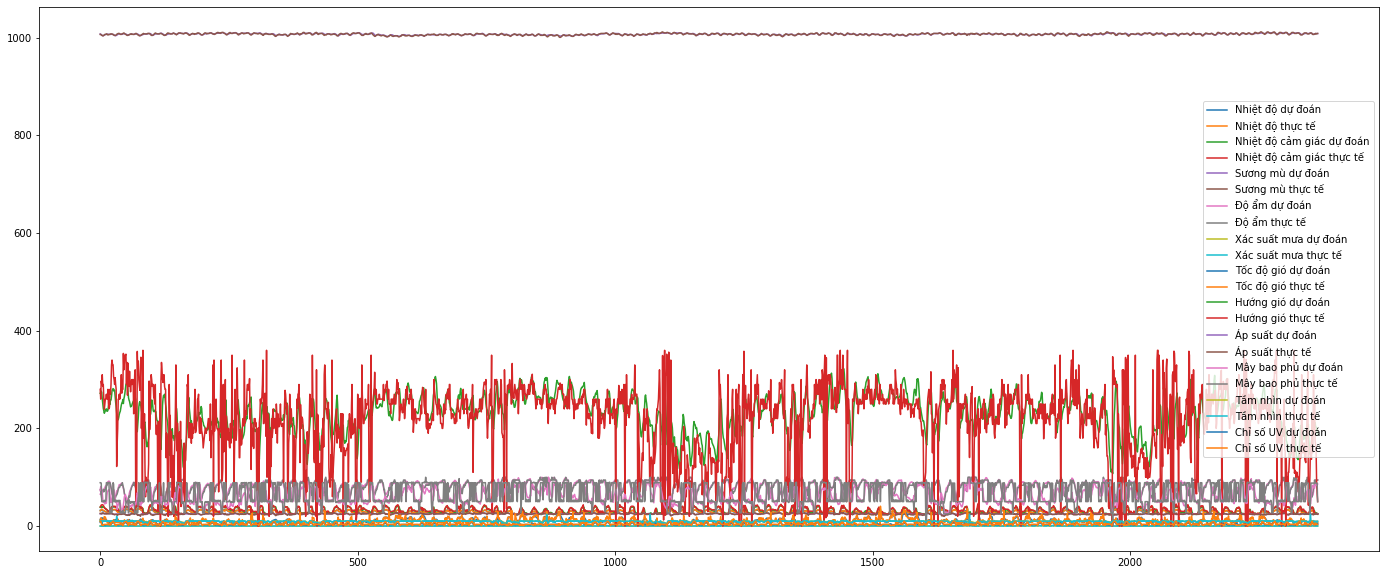

In [15]:
model = load_model(model_path)
plot_predictions(model, X_test, y_test, df_temp)

##### Biểu đồ từng đặc trưng

Nhiệt độ

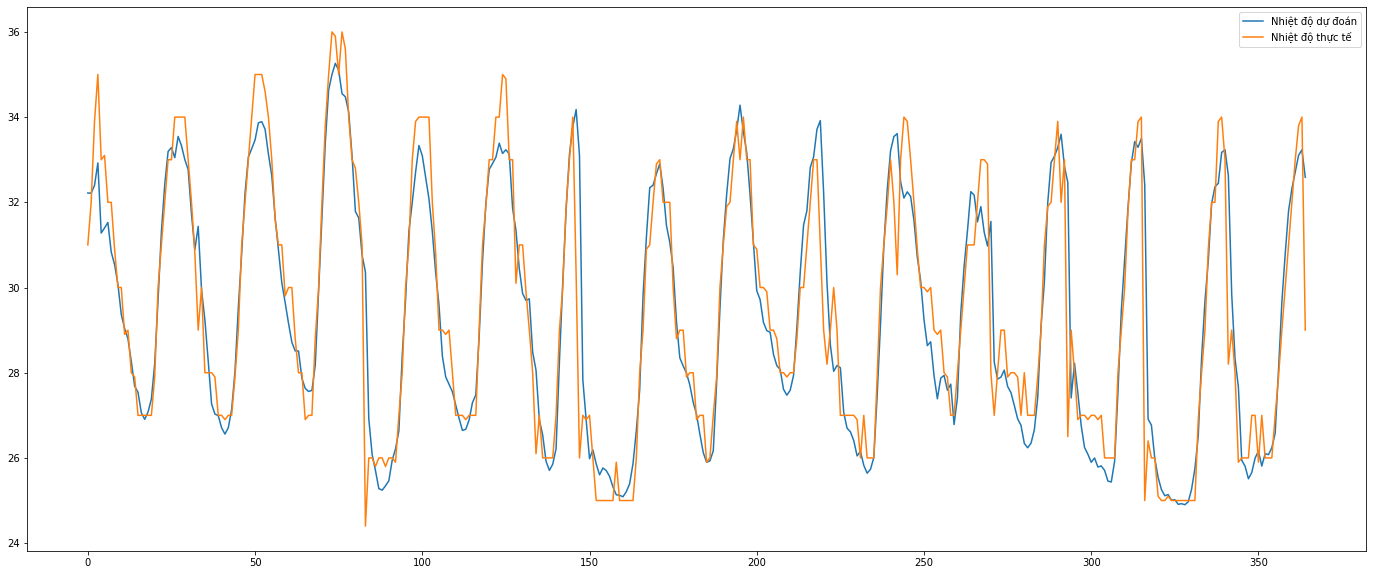

In [16]:
plot_prediction('Nhiệt độ', 0, -2000)

Nhiệt độ cảm giác

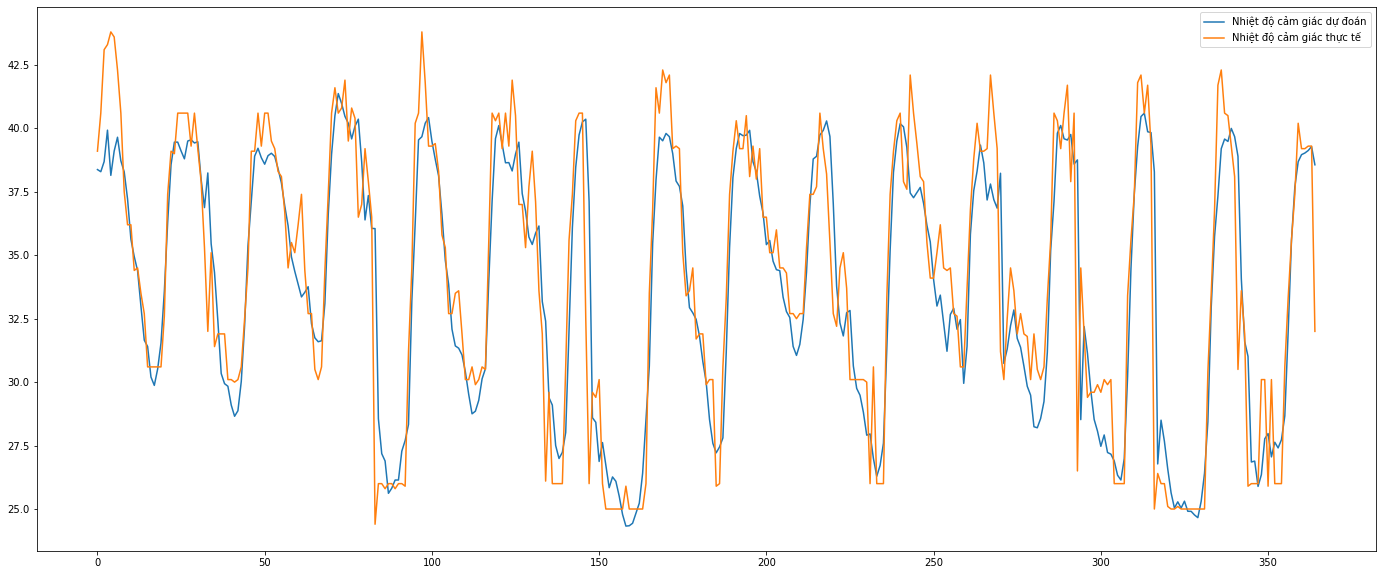

In [17]:
plot_prediction('Nhiệt độ cảm giác', 0, -2000)

Độ ẩm

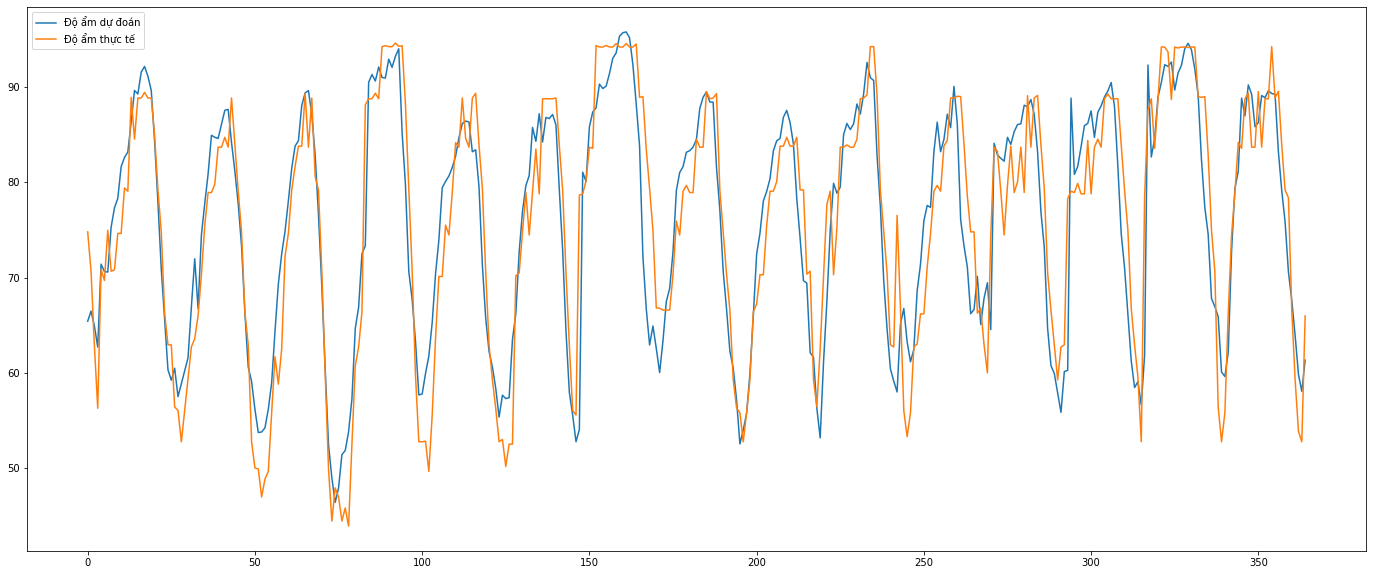

In [18]:
plot_prediction('Độ ẩm', 0, -2000)

Xác suất mưa

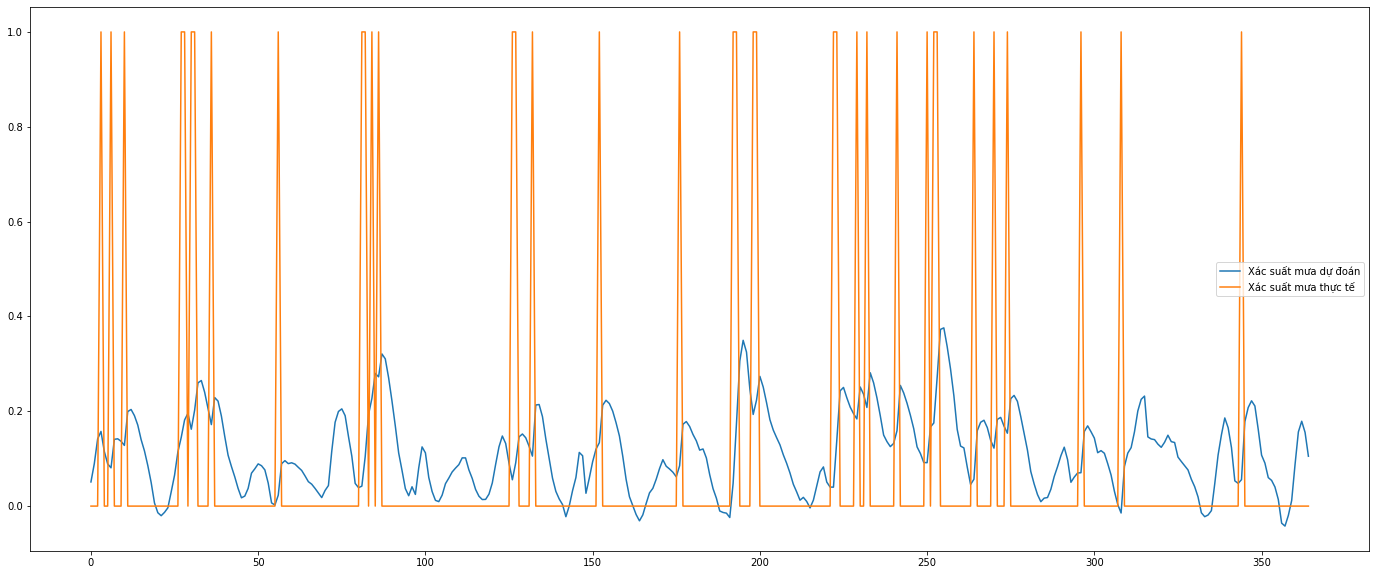

In [19]:
plot_prediction('Xác suất mưa', 0, -2000)

Áp suất

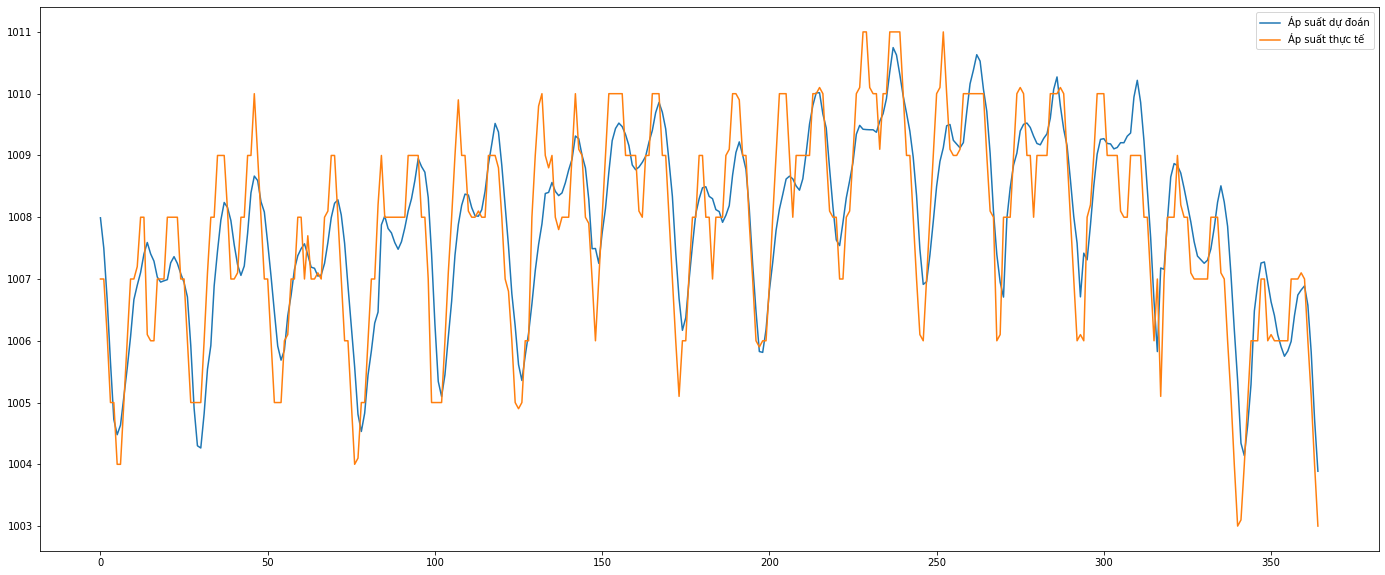

In [20]:
plot_prediction('Áp suất', 0, -2000)

Tốc độ gió

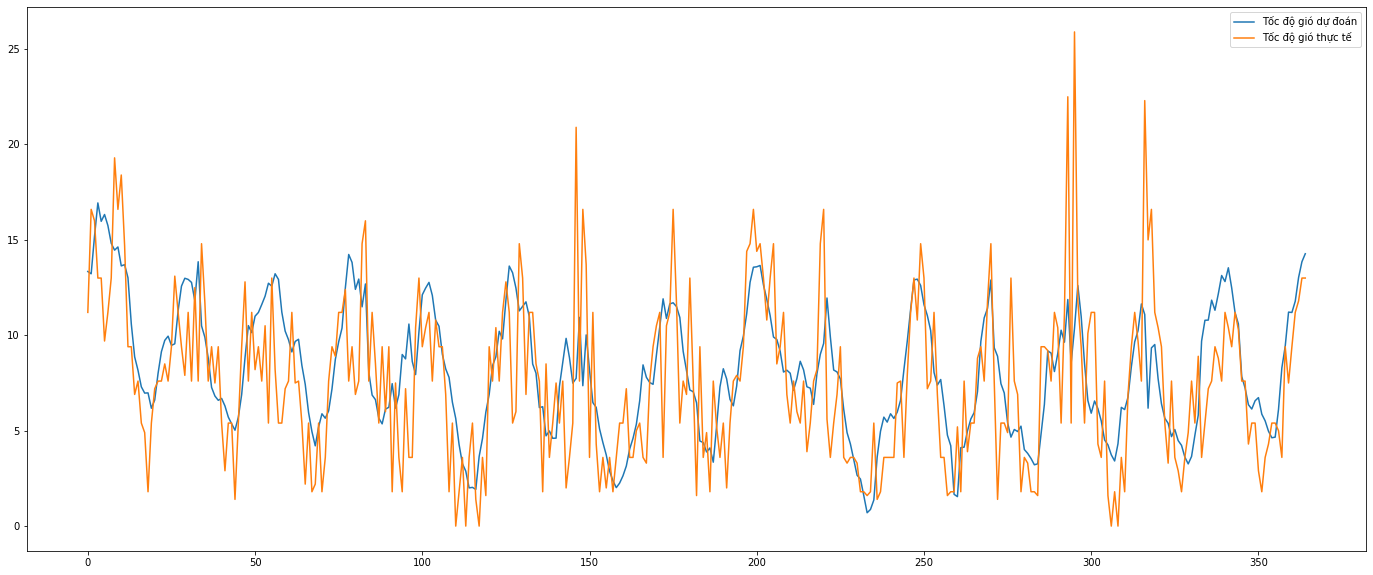

In [21]:
plot_prediction('Tốc độ gió', 0, -2000)

Hướng gió

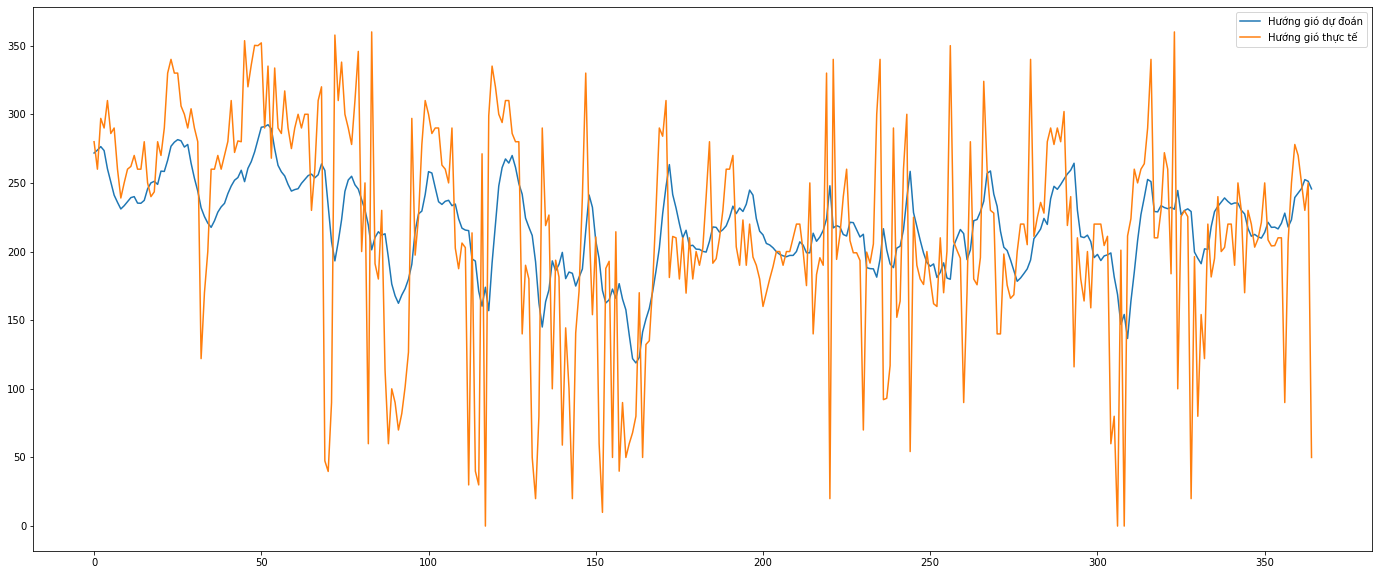

In [22]:
plot_prediction('Hướng gió', 0, -2000)

Sương mù

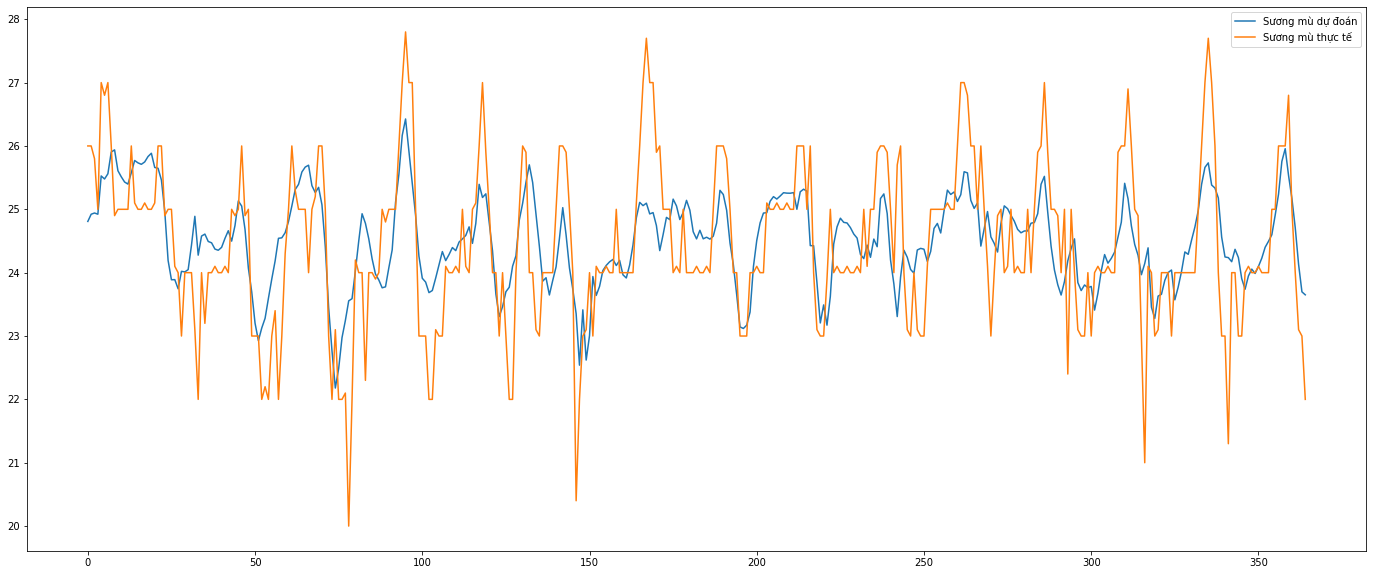

In [23]:
plot_prediction('Sương mù', 0, -2000)

Mây bao phủ

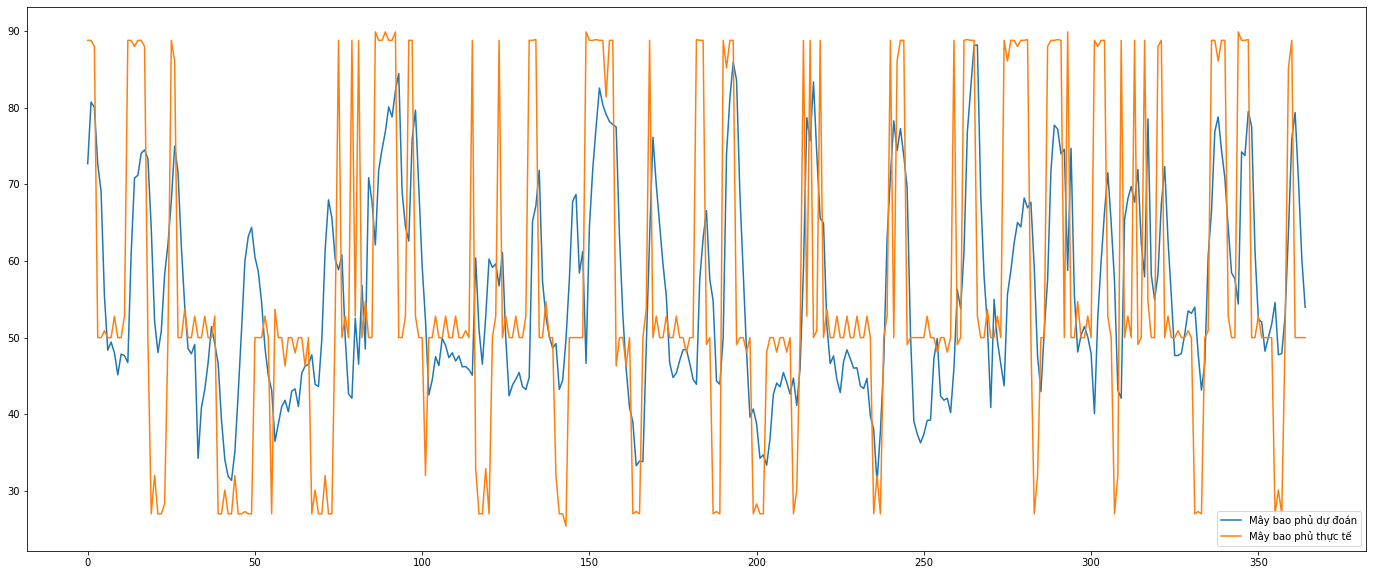

In [24]:
plot_prediction('Mây bao phủ', 0, -2000)

Tầm nhìn

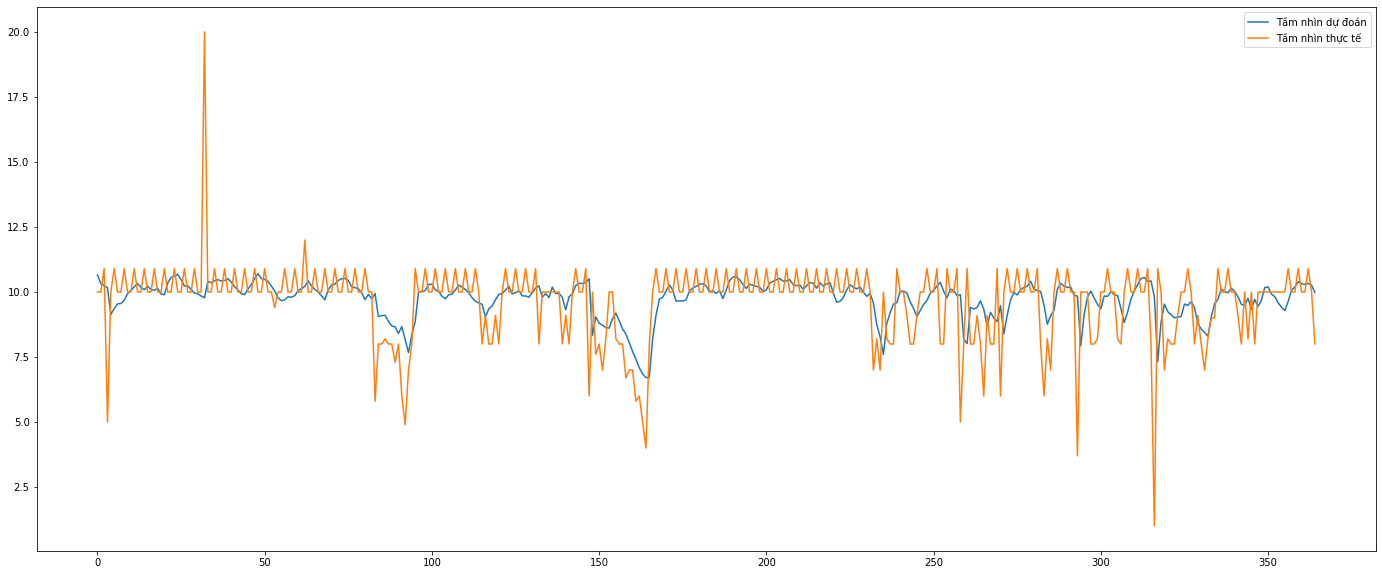

In [25]:
plot_prediction('Tầm nhìn', 0, -2000)

Chỉ số UV

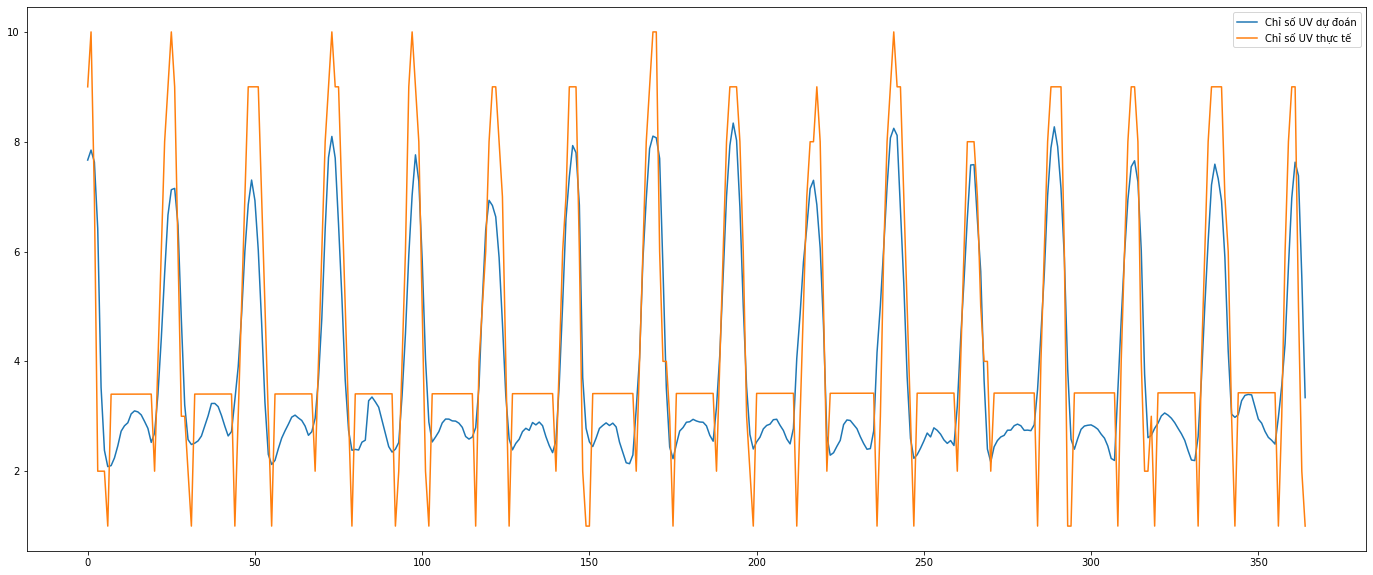

In [26]:
plot_prediction('Chỉ số UV', 0, -2000)

# Kiểm tra mô hình

In [28]:
# Load mô hình
model = load_model(model_path)

# Tạo dữ liệu để kiểm tra
df_test = df[-24:]

# Tạo đầu vào
df_as_np = df_test.to_numpy()
X_predict = []
row = [r for r in df_as_np]
X_predict.append(row)
X_predict = to_float32(X_predict)
for i in range(len(df_test.columns) - 4):
  X_predict[:, :, i] = nomralize_data(X_predict[:, :, i], mean[i], std[i])

# Dự đoán
Y_predict = model.predict(X_predict)
predicts = []
for i in range(Y_predict.shape[1]):
  predicts.append(re_nomralize_data(Y_predict[:, i], i))

# Đưa ra bảng thông số
result_key = list(df_test.columns[0:])
result_value = predicts
result = {}
for key, value in zip(result_key, result_value):
  result[key] = value[0]

# In kết quả
print('Kết quả dự đoán:')
result

Kết quả dự đoán:


{'Nhiệt độ': 25.365726,
 'Nhiệt độ cảm giác': 25.584482,
 'Sương mù': 24.216324,
 'Độ ẩm': 92.03983,
 'Xác suất mưa': 0.15609565,
 'Tốc độ gió': 5.777389,
 'Hướng gió': 179.88724,
 'Áp suất': 1008.34125,
 'Mây bao phủ': 71.63228,
 'Tầm nhìn': 9.82158,
 'Chỉ số UV': 3.1185071}